In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from scipy.interpolate import spline
import matplotlib.pyplot as plt
%matplotlib inline
drivers = pd.read_csv("../Data/driver_ids.csv")
rides = pd.read_csv("../Data/ride_ids.csv")
rides_time = pd.read_csv("../Data/ride_timestamps.csv")
df = pd.merge(rides, drivers, how = 'left', on='driver_id')
df = pd.merge(df, rides_time[rides_time['event'] == 'requested_at'], how = 'left', on='ride_id')
df['ride_distance'] = df['ride_distance'] * 0.000621371
df['ride_duration'] = df['ride_duration']/60
df = df[df['ride_distance'] >0]

In [2]:
total_trip_cost_mile_min = (df['ride_distance'] * 1.15 + df['ride_duration'] * 0.22) * \
                         (100 + df['ride_prime_time'])/100

df['trip_fare'] =  total_trip_cost_mile_min + 2 + 1.75
df.loc[df['trip_fare'] < 6.75, 'trip_fare'] = 6.75
#For company profit assuming 25% cut + Service Fee
df['company_income'] = 1.75 + 0.25 * (df['trip_fare'] - 1.75)
df = df[df['trip_fare'] < 400.00]
df.describe()

,ride_distance,ride_duration,ride_prime_time,trip_fare,company_income
count,193314.000000,193314.000000,193314.000000,193314.000000,193314.000000
mean,4.323645,14.324875,17.311343,13.287844,4.634461
std,5.456083,9.462135,30.832070,9.621634,2.405408
min,0.000621,0.033333,0.000000,6.750000,3.000000
25%,1.530437,8.200000,0.000000,7.854898,3.276225
50%,2.497911,12.116667,0.000000,10.260145,3.877536
75%,4.472007,17.816667,25.000000,14.586922,4.959231
max,171.640690,399.650000,500.000000,280.429889,71.419972


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['driver_onboard_date'] = pd.to_datetime(df['driver_onboard_date'])
df['days_active'] = df['timestamp'] - df['driver_onboard_date'] 
df['days_active_in_days'] = df['days_active']/ pd.Timedelta(days=1)
df['ride_within_1st_week'] = df['days_active_in_days'] <= 7
df['company_income_first42days'] = df['company_income'] * (df['days_active_in_days'] <= 42)
df.head(3)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,event,timestamp,trip_fare,company_income,days_active,days_active_in_days,ride_within_1st_week,company_income_first42days
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,50,2016-03-29,requested_at,2016-04-23 02:13:50,7.489647,3.184912,25 days 02:13:50,25.092940,False,3.184912
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089049,13.483333,0,2016-03-29,requested_at,2016-03-29 19:00:49,9.118740,3.592185,0 days 19:00:49,0.792234,True,3.592185
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0,2016-03-29,requested_at,2016-06-21 11:56:31,8.192574,3.360643,84 days 11:56:31,84.497581,False,0.000000


In [5]:
pivot = pd.pivot_table(df, index = ['driver_id'], \
                       values = ['days_active_in_days', 'trip_fare', 'ride_id', 'company_income', 'timestamp', \
                                 'ride_within_1st_week', 'company_income_first42days'],\
                       aggfunc={'days_active_in_days':np.max, 'trip_fare': [np.mean, np.sum], 'ride_id': 'nunique',\
                               'company_income': [np.mean, np.sum], 'timestamp': min,\
                                'ride_within_1st_week': sum, 'company_income_first42days': sum})\
                                 .reset_index()
pivot['days_active'] = pivot['days_active_in_days']['amax']
pivot['company_avg_income'] = pivot['company_income']['mean']
pivot['company_income_total'] = pivot['company_income']['sum']
pivot['number_rides'] = pivot['ride_id']['nunique']
pivot['avg_trip_price'] = pivot['trip_fare']['mean']
pivot['trips_revenue_total'] = pivot['trip_fare']['sum']
pivot['first_trip_timestamp'] = pivot['timestamp']['min']
pivot['ride_within_1st_week'] = pivot['ride_within_1st_week']['sum']
pivot['company_income_first42days'] = pivot['company_income_first42days']['sum']
pivot = pivot[['driver_id','days_active', 'company_avg_income', 'company_income_total', \
               'number_rides', 'avg_trip_price', 'trips_revenue_total', 'first_trip_timestamp',\
               'ride_within_1st_week', 'company_income_first42days']]
pivot['avg_number_trips/day'] = pivot['number_rides'] / pivot['days_active']
pivot['avg_income/day'] = pivot['trips_revenue_total']/pivot['days_active']
pivot.columns = pivot.columns.get_level_values(0)
pivot.describe()

,days_active,company_avg_income,company_income_total,number_rides,avg_trip_price,trips_revenue_total,ride_within_1st_week,company_income_first42days,avg_number_trips/day,avg_income/day
count,837.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,837.000000,837.000000
mean,55.717755,4.657897,956.143214,206.311633,13.381589,2741.436782,24.378869,590.630199,3.891110,51.561152
std,21.734025,0.471609,800.885566,173.094063,1.886437,2303.146814,21.983543,552.886911,2.823405,37.247771
min,1.733553,3.537698,10.797826,3.000000,8.900792,27.441305,0.000000,0.000000,0.046410,0.550225
25%,42.810660,4.358345,224.345049,46.000000,12.183380,654.600593,7.000000,152.580482,1.385762,18.494330
50%,57.919271,4.548434,893.412729,200.000000,12.943737,2524.321953,19.000000,409.124110,3.544775,46.922025
75%,73.089687,4.879513,1455.899581,316.000000,14.268051,4193.123008,36.000000,945.525653,5.441663,74.658887
max,90.770984,7.650685,4231.823575,919.000000,25.352742,12102.544301,111.000000,2910.053978,20.189746,244.428560


In [6]:
less_150_rides = pivot[pivot['number_rides']<= 150]
less_150_rides.describe()

,days_active,company_avg_income,company_income_total,number_rides,avg_trip_price,trips_revenue_total,ride_within_1st_week,company_income_first42days,avg_number_trips/day,avg_income/day
count,339.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,339.000000,339.000000
mean,40.130851,4.693951,250.764428,53.205950,13.525803,723.726476,11.016018,137.081038,1.742499,23.051755
std,21.384593,0.582067,137.310127,28.364092,2.328270,406.413517,11.234662,99.046211,2.124449,26.226121
min,1.733553,3.537698,10.797826,3.000000,8.900792,27.441305,0.000000,0.000000,0.046410,0.550225
25%,24.534282,4.286508,162.374337,35.000000,11.896033,455.838325,1.000000,60.750160,0.754250,10.463442
50%,37.962095,4.558422,214.278985,45.000000,12.983690,619.818936,9.000000,148.695141,1.067151,15.237919
75%,56.474693,5.017938,286.683663,59.000000,14.821751,844.414669,16.000000,198.245033,1.799732,24.903447
max,88.761956,7.650685,860.864133,150.000000,25.352742,2655.956533,65.000000,581.713274,20.189746,244.428560


In [7]:
more_150_rides = pivot[pivot['number_rides']> 150]
more_150_rides.describe()

,days_active,company_avg_income,company_income_total,number_rides,avg_trip_price,trips_revenue_total,ride_within_1st_week,company_income_first42days,avg_number_trips/day,avg_income/day
count,498.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,498.000000,498.000000
mean,66.328117,4.626387,1572.644272,340.126000,13.255546,4504.915589,36.058000,987.032167,5.353718,70.968151
std,14.319333,0.345014,608.352717,130.485689,1.380055,1767.531588,22.431428,476.673906,2.246592,30.564341
min,27.768843,4.014645,698.614827,159.000000,10.808578,1959.709308,0.000000,0.000000,2.105977,24.924412
25%,54.047778,4.394994,1119.472084,239.750000,12.329977,3183.747176,19.000000,640.884380,3.696387,48.373096
50%,66.954433,4.547258,1419.531630,305.500000,12.939030,4078.215235,33.000000,904.460622,4.930072,64.072959
75%,78.489300,4.790669,1904.967517,410.250000,13.912675,5387.341829,50.000000,1251.463491,6.492027,86.084355
max,90.770984,6.676632,4231.823575,919.000000,21.456530,12102.544301,111.000000,2910.053978,14.362527,207.318282


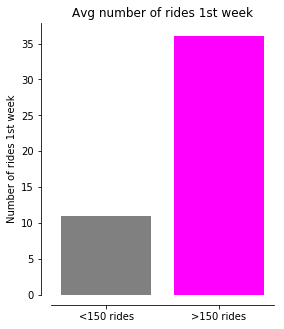

In [8]:
plt.figure(figsize=(4, 5))
x = [11.016018,36.058000]
plt.bar(x = ('<150 rides', '>150 rides'), height = x, align='center', color=('gray', 'fuchsia'))
plt.ylabel('Number of rides 1st week')
plt.title('Avg number of rides 1st week')
sns.despine(offset=10)

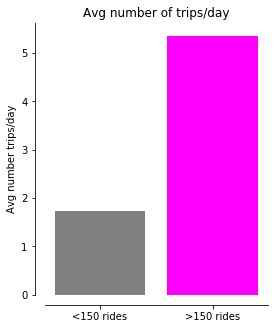

In [167]:
plt.figure(figsize=(4, 5))
y = [1.742499,5.353718]
plt.bar(x = ('<150 rides', '>150 rides'), height = y, align='center',  color=('gray', 'fuchsia'))
plt.ylabel('Avg number trips/day')
plt.title('Avg number of trips/day')
sns.despine(offset=10)

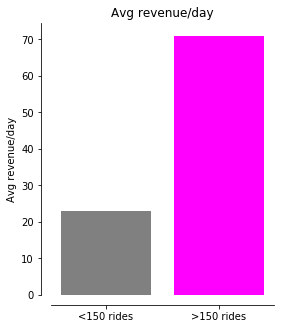

In [170]:
plt.figure(figsize=(4, 5))
z = [23.051755,70.968151]
plt.bar(x = ('<150 rides', '>150 rides'), height = z, align='center',  color=('gray', 'fuchsia'))
plt.ylabel('Avg revenue/day')
plt.title('Avg revenue/day')
sns.despine(offset=10)

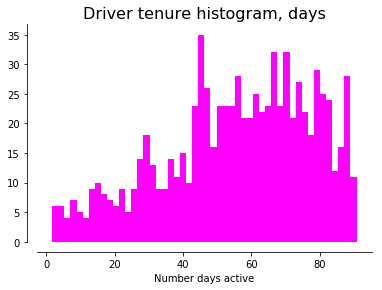

In [130]:
plt.title('Driver tenure histogram, days', fontsize = 16)
pivot['days_active'].hist(bins = 50, facecolor='fuchsia')
plt.xlabel('Number days active')
plt.grid(False)
sns.despine(offset=10)

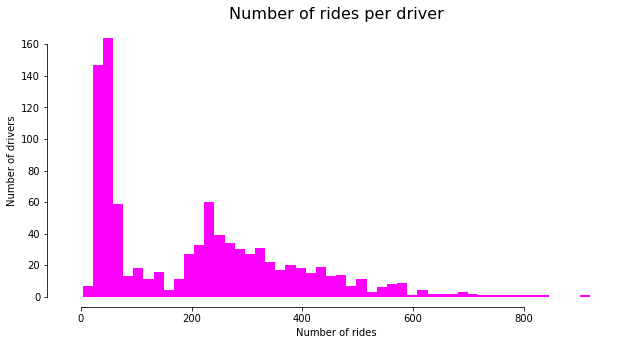

In [208]:
plt.figure(figsize=(10, 5))
plt.title('Number of rides per driver', fontsize = 16)
pivot['number_rides'].hist(bins = 50, facecolor='fuchsia')
plt.xlabel('Number of rides')
plt.ylabel('Number of drivers')
plt.grid(False)
sns.despine(offset=10, trim=True)
#plt.xlim((0, 300))

C:\Users\AL\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,'Number of drivers')

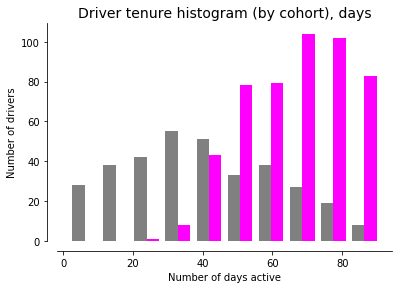

In [125]:
plt.title('Driver tenure histogram (by cohort), days', fontsize = 14)
x = pivot.loc[(pivot['days_active'].notnull()) & (pivot['number_rides'] < 150), 'days_active']
y = pivot.loc[(pivot['days_active'].notnull()) & (pivot['number_rides'] >= 150), 'days_active']
plt.hist([x, y], color=('gray', 'fuchsia'), label = ('< 150','>= 150'))
sns.despine(offset=10)
plt.xlabel('Number of days active')
plt.ylabel('Number of drivers')

Text(0.5,1,'Average revenue/day')

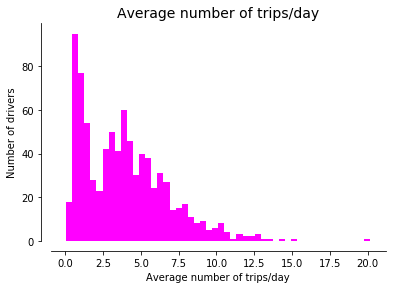

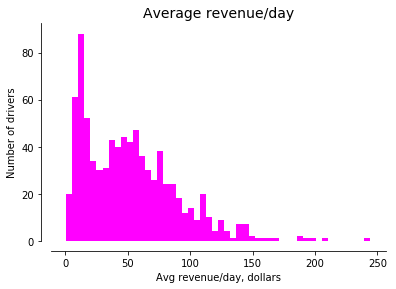

In [177]:
plt.hist(pivot.loc[pivot['avg_number_trips/day'].notnull(), 'avg_number_trips/day'], color= 'fuchsia', bins = 50)
sns.despine(offset=10)
plt.xlabel('Average number of trips/day')
plt.ylabel('Number of drivers')
plt.title('Average number of trips/day', fontsize = 14)

plt.figure()
plt.hist(pivot.loc[pivot['avg_income/day'].notnull(), 'avg_income/day'], bins =50, color = 'fuchsia')
sns.despine(offset=10)
plt.xlabel('Avg revenue/day, dollars')
plt.ylabel('Number of drivers')
plt.title('Average revenue/day', fontsize = 14)

Text(0.5,1,'Average revenue/day')

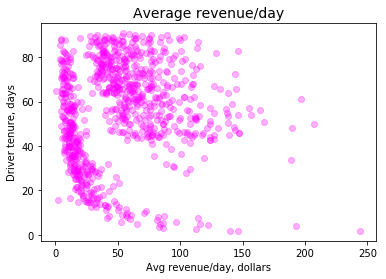

In [188]:
plt.scatter(pivot['avg_income/day'], pivot['days_active'], alpha=0.3, color = 'fuchsia')
#plt.xlim((40, 90))
#plt.ylim((1000, 12000))
plt.xlabel('Avg revenue/day, dollars')
plt.ylabel('Driver tenure, days')
plt.title('Average revenue/day', fontsize = 14)

Text(0.5,1,'Number of rides per tenure')

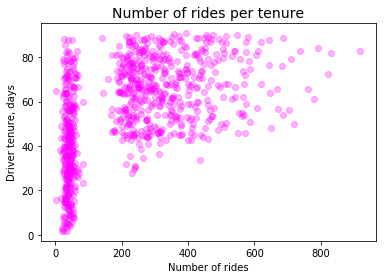

In [195]:
plt.scatter(pivot['number_rides'], pivot['days_active'], alpha=0.3, color = 'fuchsia') 
plt.xlabel('Number of rides')
plt.ylabel('Driver tenure, days')
plt.title('Number of rides per tenure', fontsize = 14)

Text(0.5,1,'company income total per driver')

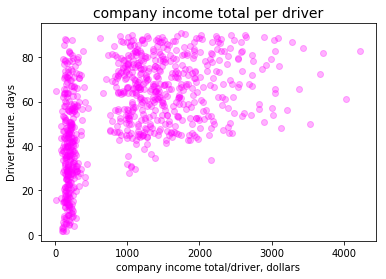

In [9]:
plt.scatter(pivot['company_income_total'], pivot['days_active'], alpha=0.3, color = 'fuchsia') 
plt.xlabel('company income total/driver, dollars')
plt.ylabel('Driver tenure. days')
plt.title('company income total per driver', fontsize = 14)

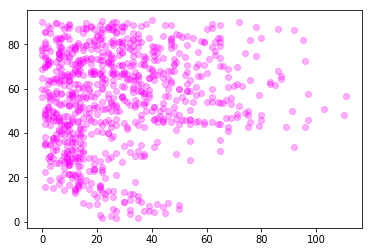

In [181]:
plt.scatter(pivot['ride_within_1st_week'], pivot['days_active'],  alpha=0.3, color = 'fuchsia') 

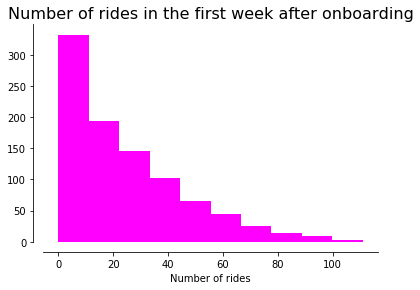

In [201]:
pivot['ride_within_1st_week'].hist( color='fuchsia')
plt.title('Number of rides in the first week after onboarding', fontsize = 16)

plt.xlabel('Number of rides')

sns.despine(offset=10)
plt.grid(False)

## Drivers churn rate

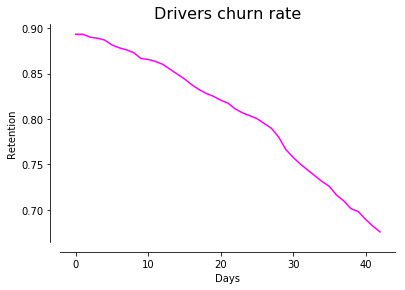

In [197]:
df_churn = pd.merge(drivers, pivot, how = 'left', on='driver_id')
df_churn = df_churn[['driver_id', 'driver_onboard_date', 'days_active', 'first_trip_timestamp']]

retention_rates_by_day = []

for i in range(43):
    retention = (df_churn['days_active'] >= i).mean()
    retention_rates_by_day.append(retention)
    
plt.plot(retention_rates_by_day, color='fuchsia')

plt.title('Drivers churn rate', fontsize = 16)

plt.xlabel('Days')
plt.ylabel('Retention')
sns.despine(offset=10)
